# Fine-Tuning MobileNetV2 for Malaria Detection
In this notebook, we fine-tune the top layers of a pretrained MobileNetV2 model previously trained on the malaria dataset. The goal is to improve validation accuracy beyond the frozen transfer learning baseline.

In [32]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import shutil
import os
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score # Evaluation metrics
import matplotlib.pyplot as plt # Plot graphs and images
import seaborn as sns

# Import MobileNetV2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

## Download Malaria Kaggle Dataset

In [16]:
RAW_DATA_DIR = "data/raw"
BASE_DIR = os.path.join(RAW_DATA_DIR, "cell_images") # Where Kaggle dataset is unzipped
CLEAN_DIR = os.path.join(RAW_DATA_DIR, "clean_cell_images") # Clean folder for training

# Make sure raw folder exists
os.makedirs(RAW_DATA_DIR, exist_ok=True)

# Set Kaggle config directory to current folder
os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd()

# Check for kaggle.json (you need to upload it in Colab first)
if not os.path.exists('kaggle.json'):
    raise FileNotFoundError("Kaggle API token file 'kaggle.json' not found. Please upload it to the current directory.")

# Download & unzip dataset **only if it doesn't exist**
if not os.path.exists(BASE_DIR):
    !kaggle datasets download -d 'iarunava/cell-images-for-detecting-malaria' -p {RAW_DATA_DIR} --unzip
else:
    print("Dataset already downloaded and unzipped.")

# Detect whether there is a nested cell_images folder
if os.path.exists(os.path.join(BASE_DIR, "cell_images")):
  # Nested case: cell_images/cell_images/Parasitized
  DATA_SOURCE_DIR = os.path.join(BASE_DIR, "cell_images")
else:
  # Normal case: cell_images/Parasitized
  DATA_SOURCE_DIR = BASE_DIR

print("Using data source dictionary:", DATA_SOURCE_DIR)

# Remove old clean folder if it exists
if os.path.exists(CLEAN_DIR):
  shutil.rmtree(CLEAN_DIR)

# Copy clean structure
shutil.copytree(
    os.path.join(DATA_SOURCE_DIR, "Parasitized"),
    os.path.join(CLEAN_DIR, "Parasitized")
)

shutil.copytree(
    os.path.join(DATA_SOURCE_DIR, "Uninfected"),
    os.path.join(CLEAN_DIR, "Uninfected")
)

print("Clean dataset ready at:", CLEAN_DIR)

Dataset already downloaded and unzipped.
Using data source dictionary: data/raw/cell_images/cell_images
Clean dataset ready at: data/raw/clean_cell_images


## Load Data

In [17]:
DATA_SET_PATH = 'data/raw/clean_cell_images'
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

In [18]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    DATA_SET_PATH,
    target_size=IMG_SIZE,
    class_mode="binary",
    subset="training",
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    DATA_SET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",
    shuffle=False
)

Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


## Load Frozen MobileNetV2 Model

In [19]:
model = load_model("/content/models/malaria_mobilenetv2_frozen.keras")
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,750,277 (10.49 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 328,196 (1.25 MB)

## Unfreeze Top Layers for Fine-Tuning

In [20]:
# Freeze most layers, unfreeze top layers
for layer in model.layers:
  layer.trainable = False

# Unfreeze last 30 layers
for layer in model.layers[-30:]:
  layer.trainable = True

print("Trainable layers after unfreezing:")
for layer in model.layers[-40:]:
  print(layer.name, layer.trainable)

Trainable layers after unfreezing:
block_13_expand_relu False
block_13_pad False
block_13_depthwise False
block_13_depthwise_BN False
block_13_depthwise_relu False
block_13_project False
block_13_project_BN False
block_14_expand False
block_14_expand_BN False
block_14_expand_relu False
block_14_depthwise True
block_14_depthwise_BN True
block_14_depthwise_relu True
block_14_project True
block_14_project_BN True
block_14_add True
block_15_expand True
block_15_expand_BN True
block_15_expand_relu True
block_15_depthwise True
block_15_depthwise_BN True
block_15_depthwise_relu True
block_15_project True
block_15_project_BN True
block_15_add True
block_16_expand True
block_16_expand_BN True
block_16_expand_relu True
block_16_depthwise True
block_16_depthwise_BN True
block_16_depthwise_relu True
block_16_project True
block_16_project_BN True
Conv_1 True
Conv_1_bn True
out_relu True
global_average_pooling2d True
dense_2 True
dropout_1 True
dense_3 True


## Recompile with Small Learning Rate

In [21]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=['accuracy']
)

### Train the Fine-Tuned MobileNetV2 Model

In [28]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=3,
    min_lr=1e-6
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


689/689 ━━━━━━━━━━━━━━━━━━━━ 48s 43ms/step - accuracy: 0.8975 - loss: 0.2807 - val_accuracy: 0.8935 - val_loss: 0.3453 - learning_rate: 1.0000e-05
Epoch 2/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 29s 42ms/step - accuracy: 0.9384 - loss: 0.1769 - val_accuracy: 0.9100 - val_loss: 0.2655 - learning_rate: 1.0000e-05
Epoch 3/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 29s 42ms/step - accuracy: 0.9509 - loss: 0.1391 - val_accuracy: 0.9201 - val_loss: 0.2201 - learning_rate: 1.0000e-05
Epoch 4/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 29s 42ms/step - accuracy: 0.9528 - loss: 0.1276 - val_accuracy: 0.9363 - val_loss: 0.1861 - learning_rate: 1.0000e-05
Epoch 5/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 29s 42ms/step - accuracy: 0.9629 - loss: 0.1035 - val_accuracy: 0.9401 - val_loss: 0.1793 - learning_rate: 1.0000e-05
Epoch 6/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 29s 42ms/step - accuracy: 0.9648 - loss: 0.0946 - val_accuracy: 0.9417 - val_loss: 0.1851 - learning_rate: 1.0000e-05
Epoch 7/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 29s 42ms/step - accurac

## Final Evaluation

In [30]:
loss, acc = model.evaluate(val_generator)
print(f"Fine-tuned validation loss: {loss:.4f}")
print(f"Fine-tuned validation accuracy: {acc:.4f}")

173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.9299 - loss: 0.2058
Fine-tuned validation loss: 0.1793
Fine-tuned validation accuracy: 0.9401


## Confusion Matrix

173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step


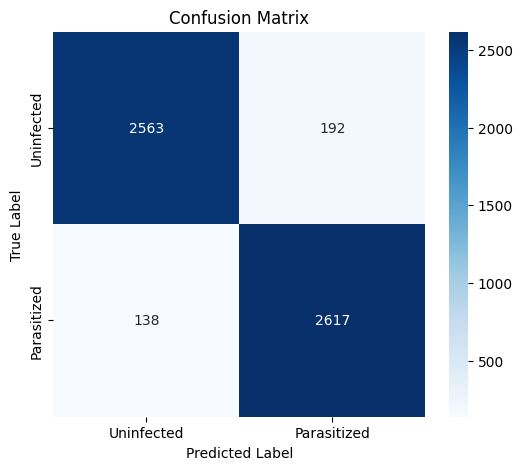

In [35]:
# Evaluate MobileNetV2 Fine-tuned
val_probs = model.predict(val_generator)
y_pred = (val_probs > 0.5).astype(int).ravel()
y_true = val_generator.classes

cm_finetuned = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm_finetuned, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Uninfected", "Parasitized"],
            yticklabels=["Uninfected", "Parasitized"])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Precision, Recall, F1 Score

In [36]:
print(classification_report(y_true, y_pred, target_names=['Uninfected', 'Parasitized']))

f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

              precision    recall  f1-score   support

  Uninfected       0.95      0.93      0.94      2755
 Parasitized       0.93      0.95      0.94      2755

    accuracy                           0.94      5510
   macro avg       0.94      0.94      0.94      5510
weighted avg       0.94      0.94      0.94      5510

Precision: 0.9316
Recall: 0.9499
F1 Score: 0.9407


## Plot Training Curves (Accuracy + Loss)

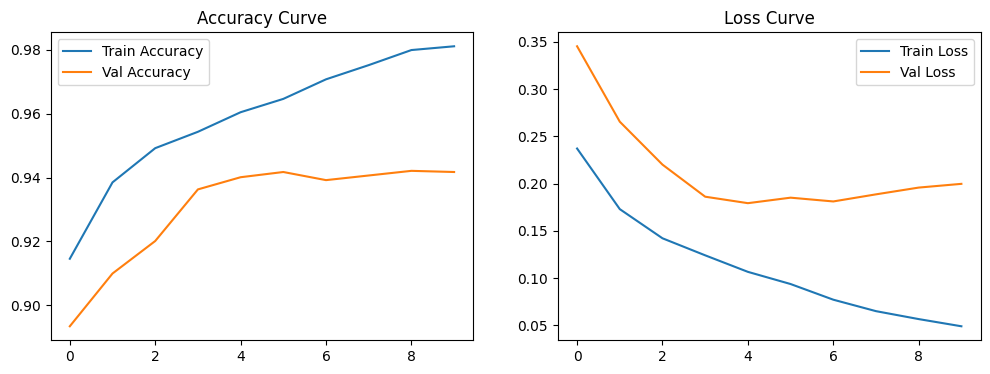

In [37]:
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy Curve')

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Curve')

plt.show()

## Save Fine-Tuned Model

In [40]:
from google.colab import files

model.save("/content/models/malaria_mobilenetv2_finetuned.keras")
files.download('/content/models/malaria_mobilenetv2_finetuned.keras')
print("Fine-tuned model saved!")

# Save confusion matrices
np.save("mobilenetv2_frozen_cm.npy", cm_finetuned)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fine-tuned model saved!
